In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

In [19]:
# Crea i dati per predire il prezzo a distanza di una settimana

stock = "AAPL"

df = pd.read_csv(
    f"csv/{stock}_indicators.csv",
    index_col=0,       # use first column ("Date") as index
    parse_dates=[0],    # parse it as datetime
    date_format="ISO8601" #Specify date fromat
) 

df["Train"] = df["Close"].shift(-3)
df.dropna(subset=['Train'], inplace=True)

X = df.drop(columns=["Train", "BSH"])
Y = df["Train"]
tscv = TimeSeriesSplit(n_splits=5)

data_set = []
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    
    data_set.append({
        "X_train": X_train.drop(columns=["Close"]).copy(),
        "X_test": X_test.drop(columns=["Close"]).copy(),
        "Y_train": Y_train.copy(),
        "Y_test": Y_test.copy(),
        "Reality": X_test["Close"].copy()
    })

Stock: AAPL
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 0.2266 | MAE: 0.1658 | R2: 0.9812 | base R2: 0.9876
Top coefficients:
Adj Close        0.117546
High             0.029606
Low              0.012495
Next_Return      0.001355
Boll_Down        0.001226
Volume           0.000000
Return           0.000000
Month            0.000000
Return_mean_5    0.000000
Open             0.000000


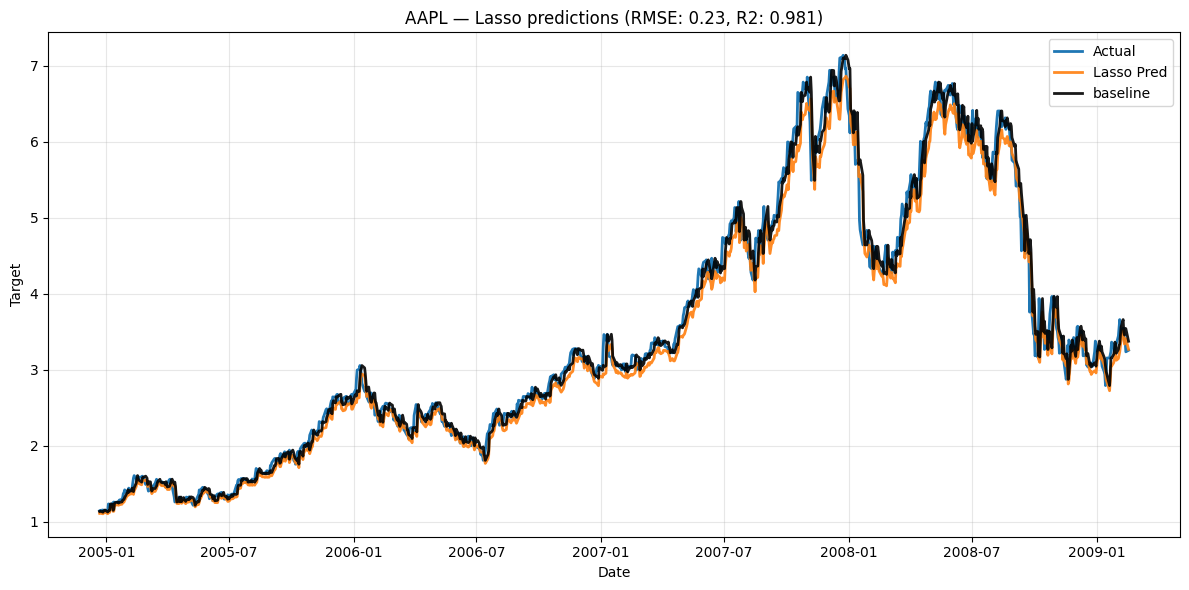

Stock: AAPL
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 0.4570 | MAE: 0.3335 | R2: 0.9934 | base R2: 0.9940
Top coefficients:
Adj Close      1.727597
Low            0.108866
High           0.057249
Next_Return    0.039118
Vol_EMA200     0.013961
MACD           0.006036
MACD_Hist      0.002349
Return         0.000000
Volume         0.000000
Open           0.000000


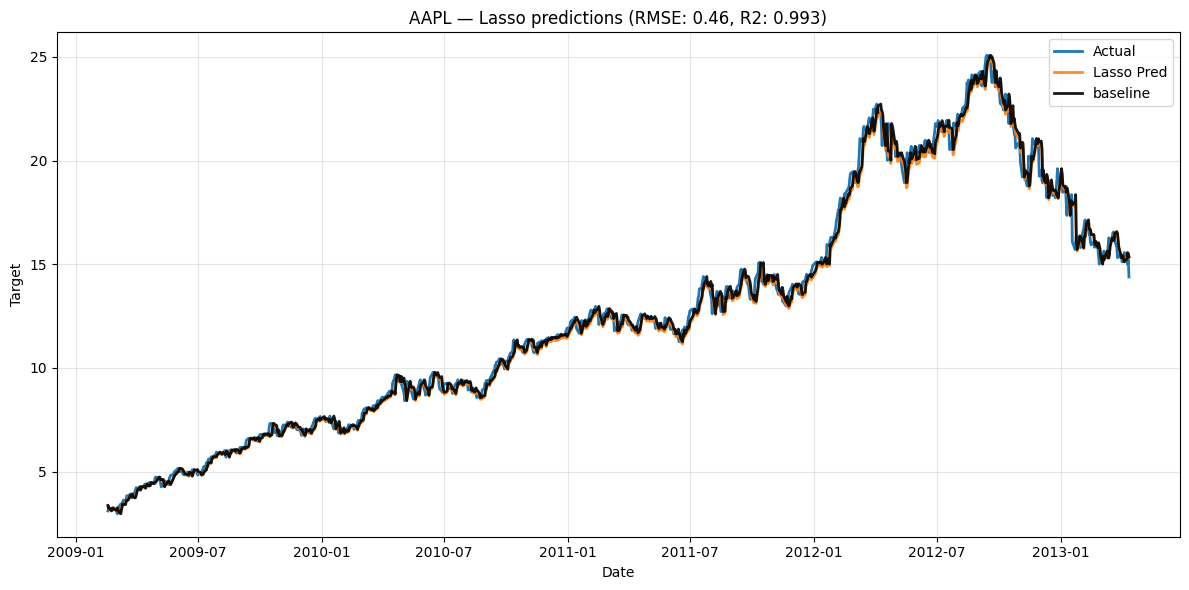

Stock: AAPL
Best params: {'lasso__alpha': 0.01, 'lasso__max_iter': 10000}
RMSE: 1.8411 | MAE: 1.5333 | R2: 0.8986 | base R2: 0.9873
Top coefficients:
Adj Close         5.914692
High              0.123159
Next_Return       0.079476
Close_lag7        0.047835
Close_lag1        0.041009
Boll_Up           0.040356
MACD_Signal       0.037607
Return_mean_10    0.005557
Return            0.000000
Low               0.000000


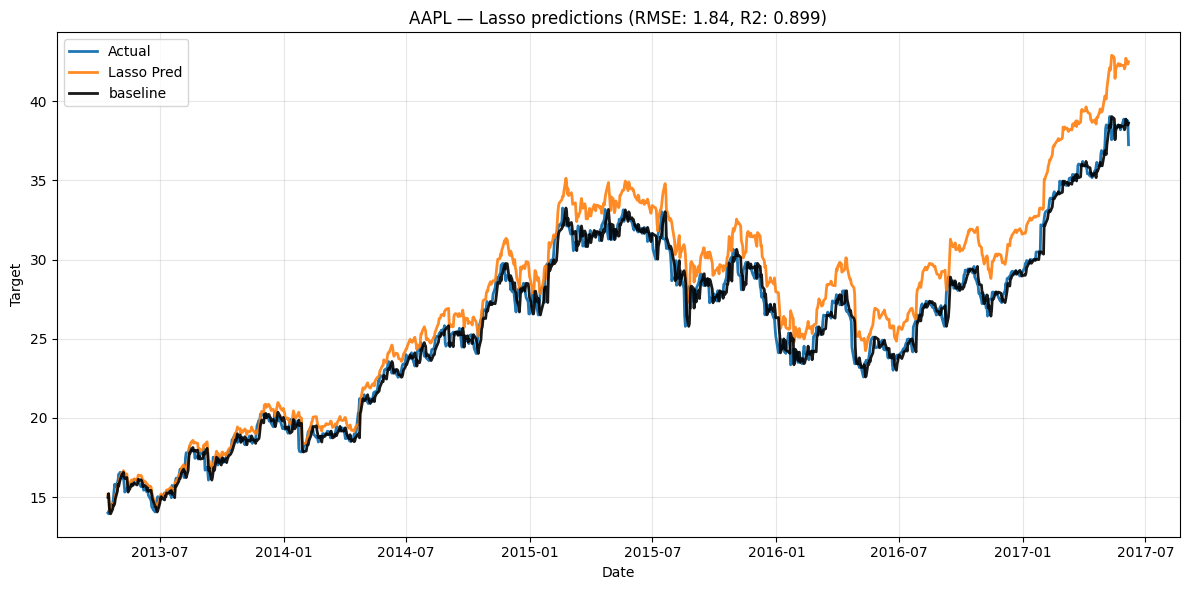

Stock: AAPL
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 2.7395 | MAE: 1.7563 | R2: 0.9936 | base R2: 0.9940
Top coefficients:
High             8.959821
Adj Close        1.342840
Low              0.252599
Next_Return      0.024659
Volume           0.000000
Open             0.000000
Return           0.000000
Month            0.000000
Return_mean_5    0.000000
Return_std_5     0.000000


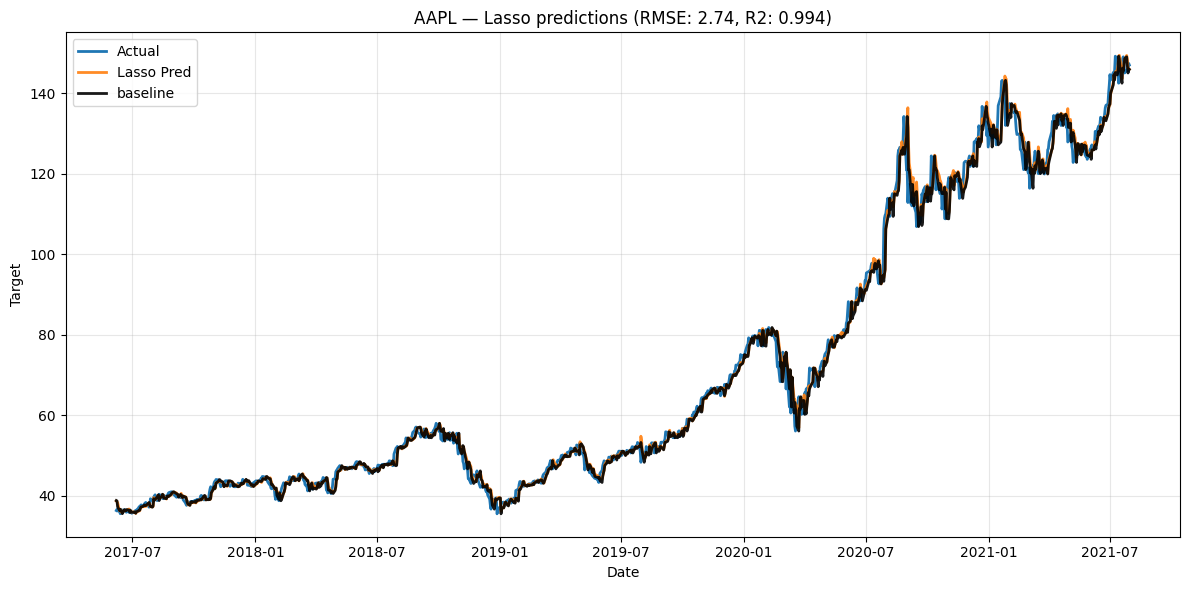

Stock: AAPL
Best params: {'lasso__alpha': 0.1, 'lasso__max_iter': 10000}
RMSE: 5.8453 | MAE: 4.2913 | R2: 0.9667 | base R2: 0.9672
Top coefficients:
Low              17.653466
High              8.705841
Adj Close         3.262385
EMA200            0.407171
Next_Return       0.224313
Volume            0.000000
Return            0.000000
Month             0.000000
Return_mean_5     0.000000
Open              0.000000


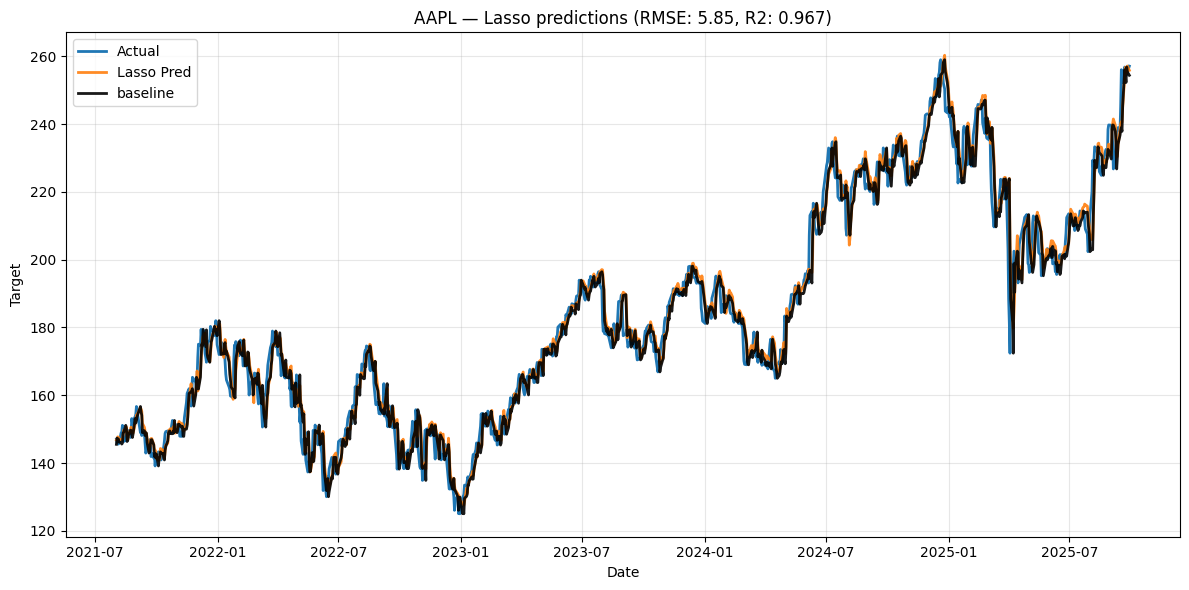

In [20]:
#Lasso regression
for data in data_set:
    pipe = make_pipeline(StandardScaler(), Lasso(random_state=42, max_iter=20000))

    param_grid = {
        'lasso__alpha': [0.01, 0.1, 0.5, 0.5, 1.0],
        'lasso__max_iter': [10000, 50000, 100000]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    lasso = best.named_steps['lasso']
    coefs = pd.Series(lasso.coef_, index=data["X_train"].columns)
    print("Top coefficients:")
    print(coefs.abs().sort_values(ascending=False).head(10).to_string())

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='Lasso Pred', color='#ff7f0e', linewidth=2, alpha=0.9)
    plt.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    plt.title(f"{stock} — Lasso predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Stock: AAPL
Best params: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 100}
RMSE: 2.9094 | MAE: 2.3981 | R2: -2.0974 | base R2: 0.9876
Top features:
 High          0.109635
Low           0.100013
Close_lag3    0.095515
Open          0.081544
Boll_Down     0.070665
Close_lag7    0.056853
Close_lag1    0.052902
Boll_Up       0.052748
SMA           0.045834
Adj Close     0.042912


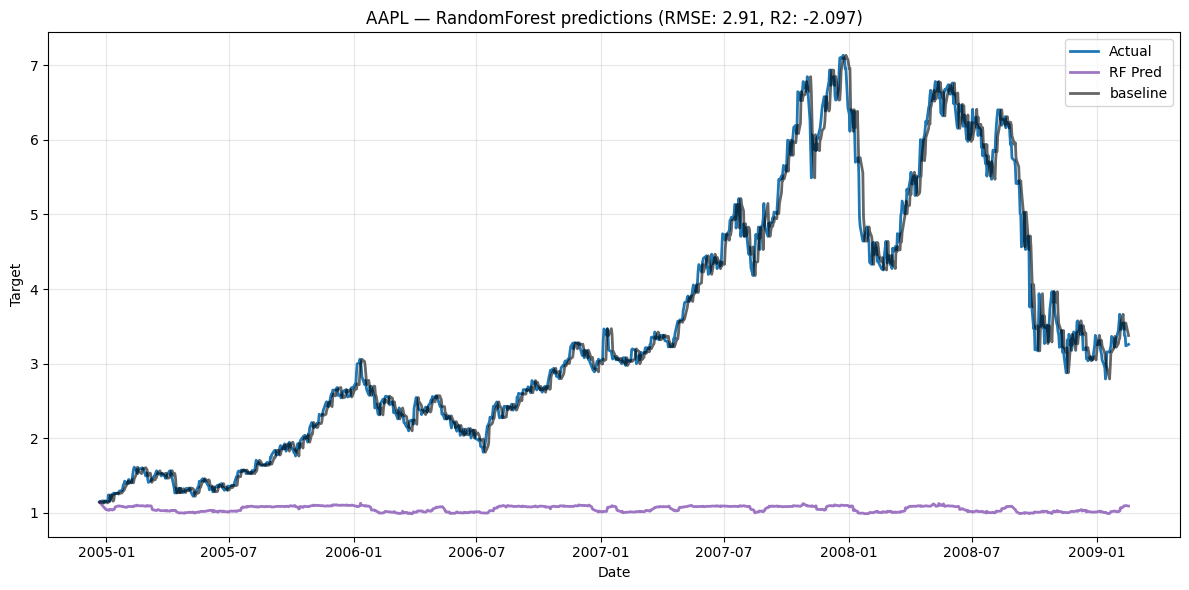

Stock: AAPL
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 8.6322 | MAE: 6.7301 | R2: -1.3494 | base R2: 0.9940
Top features:
 High          0.112235
Low           0.112133
Open          0.104025
Adj Close     0.087661
Close_lag1    0.072649
Boll_Down     0.066796
EMA200        0.058523
Close_lag7    0.047994
Boll_Up       0.046680
Close_lag3    0.045846


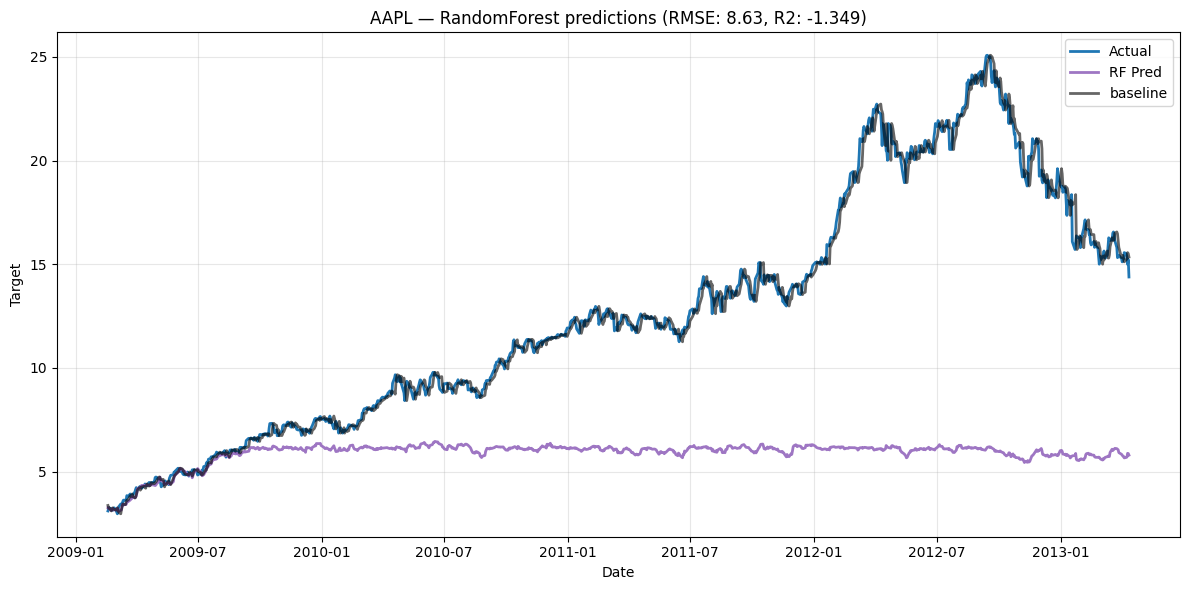

Stock: AAPL
Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
RMSE: 5.5200 | MAE: 4.0004 | R2: 0.0886 | base R2: 0.9873
Top features:
 EMA50_lag1     0.086140
Open           0.081401
Close_lag1     0.077075
High           0.074408
Close_lag7     0.073189
EMA200         0.072353
Boll_Up        0.070225
Adj Close      0.068828
Low            0.065656
EMA200_lag1    0.063204


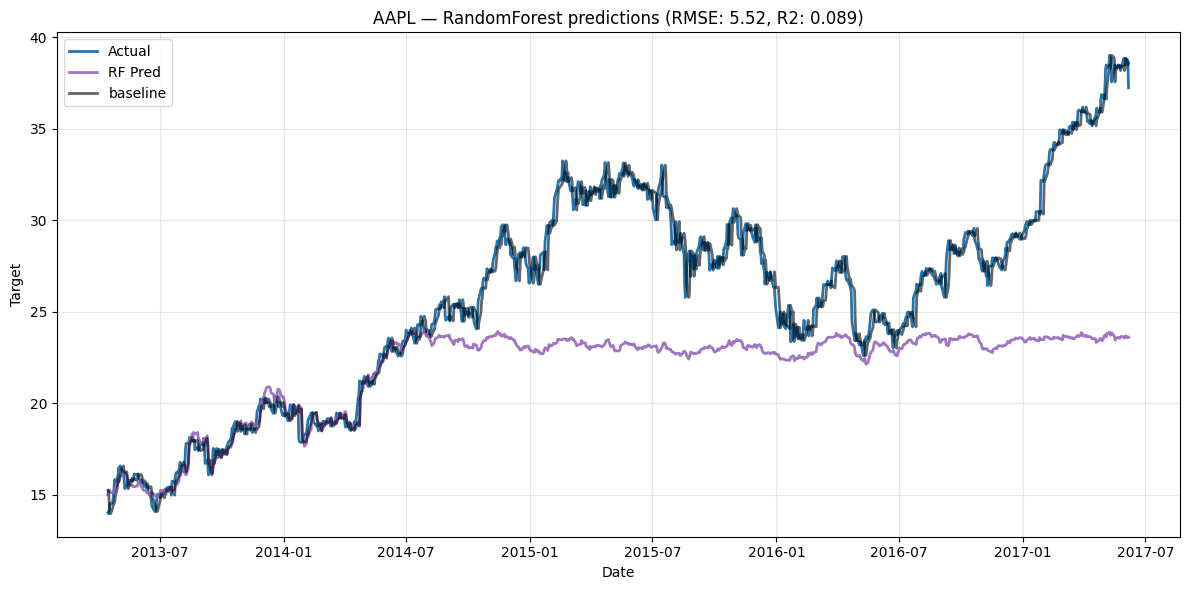

Stock: AAPL
Best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}
RMSE: 47.8868 | MAE: 33.5813 | R2: -0.9678 | base R2: 0.9940
Top features:
 High           0.117295
Low            0.113492
Adj Close      0.109667
Open           0.088458
Boll_Up        0.075955
EMA200         0.074461
Close_lag1     0.063202
EMA200_lag1    0.061520
EMA50          0.052977
EMA50_lag1     0.048202


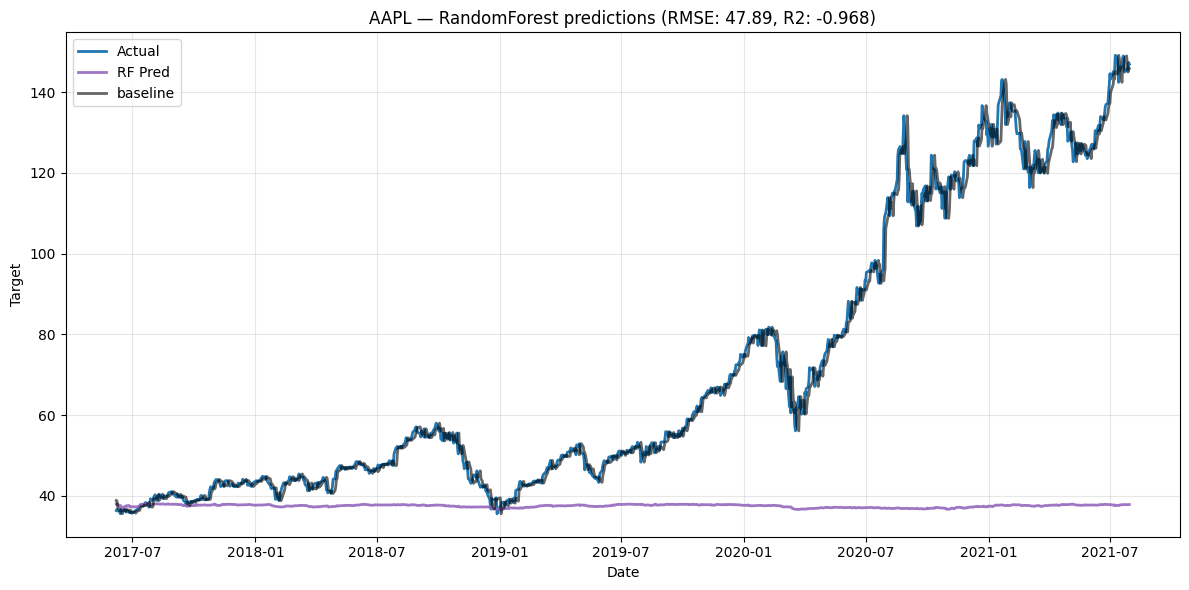

Stock: AAPL
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
RMSE: 51.2779 | MAE: 40.9147 | R2: -1.5647 | base R2: 0.9672
Top features:
 EMA50_lag1    0.093108
Boll_Up       0.088434
EMA200        0.076989
Open          0.075860
EMA50         0.071136
High          0.068598
SMA           0.068501
Close_lag3    0.060217
Close_lag1    0.059601
Close_lag7    0.059356


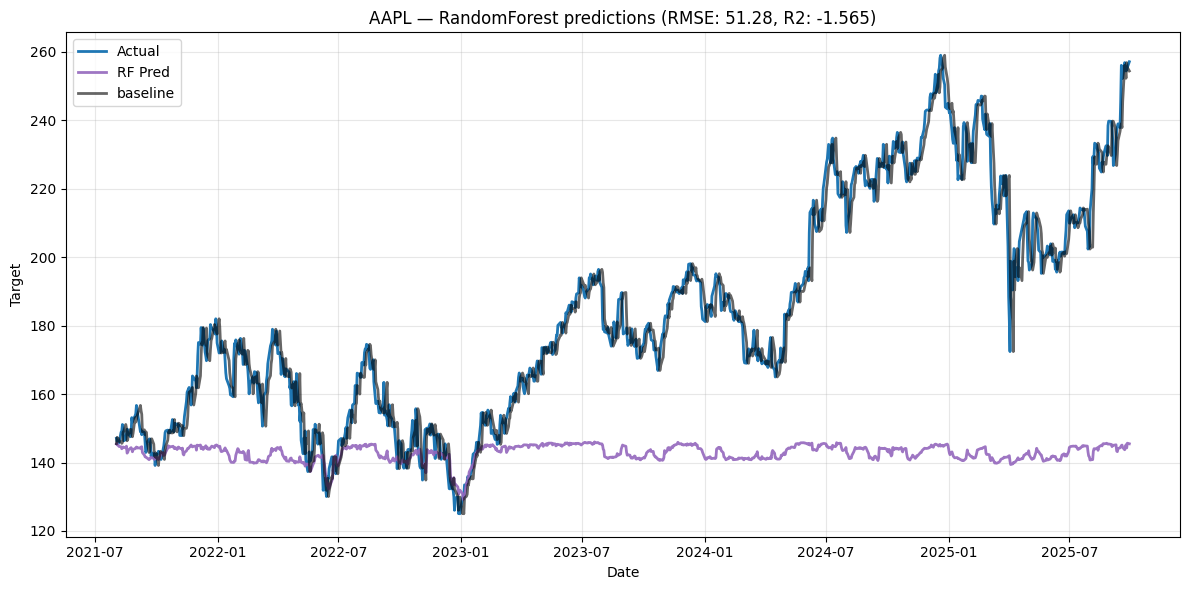

In [24]:
# Random forest regresor
for data in data_set:
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    param_grid = {
        "n_estimators": [100, 300],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "max_features": ["log2", "sqrt"]
    }

    gs = GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # feature importances
    try:
        fi = pd.Series(best.feature_importances_, index=data["X_train"].columns)
        print("Top features:\n", fi.sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='RF Pred', color='#9467bd', linewidth=2, alpha=0.9)
    plt.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.6)
    plt.title(f"{stock} — RandomForest predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.1}
RMSE: 0.2031 | MAE: 0.1363 | R2: 0.9849 | base R2: 0.9876
Top coefficients:
Adj Close      0.033239
Low            0.026839
High           0.025620
Open           0.020439
Close_lag1     0.019261
Boll_Down      0.011207
SMA            0.009856
Next_Return    0.009743
Close_lag7     0.008130
Close_lag3     0.006188


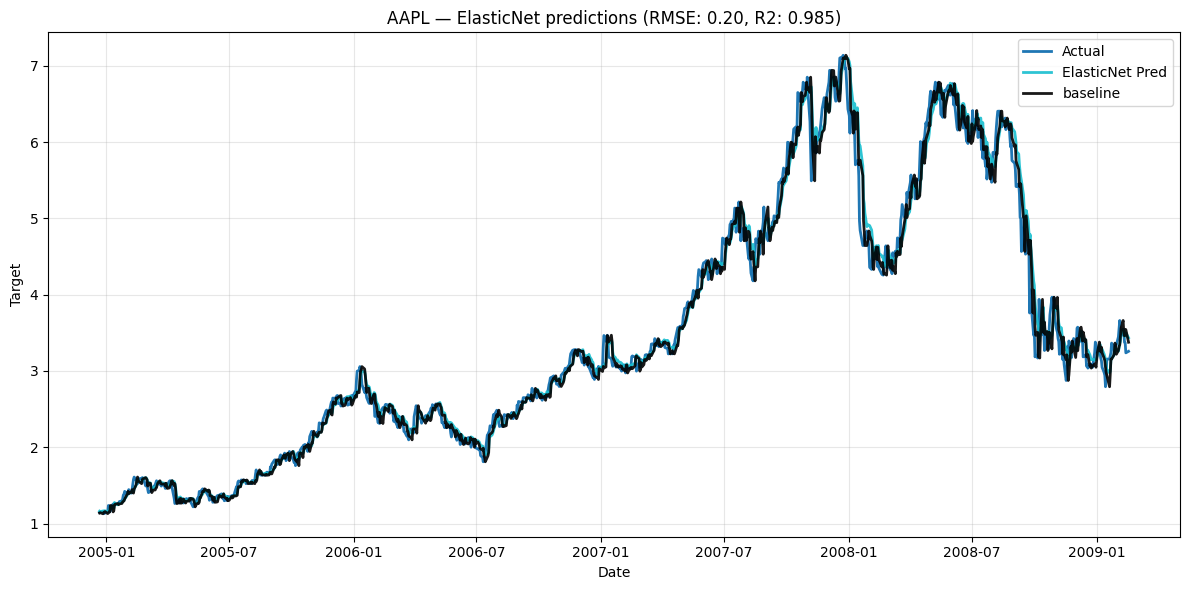

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 0.4676 | MAE: 0.3426 | R2: 0.9931 | base R2: 0.9940
Top coefficients:
Adj Close      0.680931
Low            0.552260
High           0.415820
Open           0.186632
Close_lag1     0.054809
Next_Return    0.038765
Vol_EMA200     0.017918
MACD           0.007373
MACD_Hist      0.005167
Lag1           0.002022


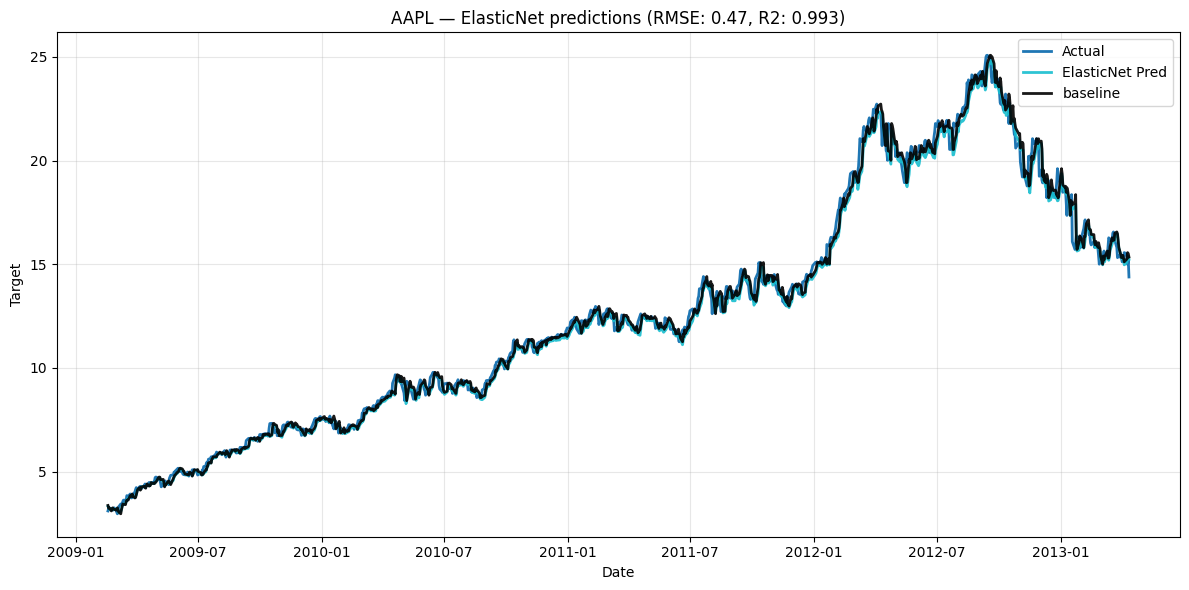

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}
RMSE: 0.7061 | MAE: 0.5368 | R2: 0.9851 | base R2: 0.9873
Top coefficients:
Adj Close     1.305105
Low           1.033361
High          0.900842
Open          0.695080
Close_lag1    0.677113
SMA           0.453459
Boll_Up       0.443737
Close_lag7    0.293656
Close_lag3    0.247242
Boll_Down     0.106351


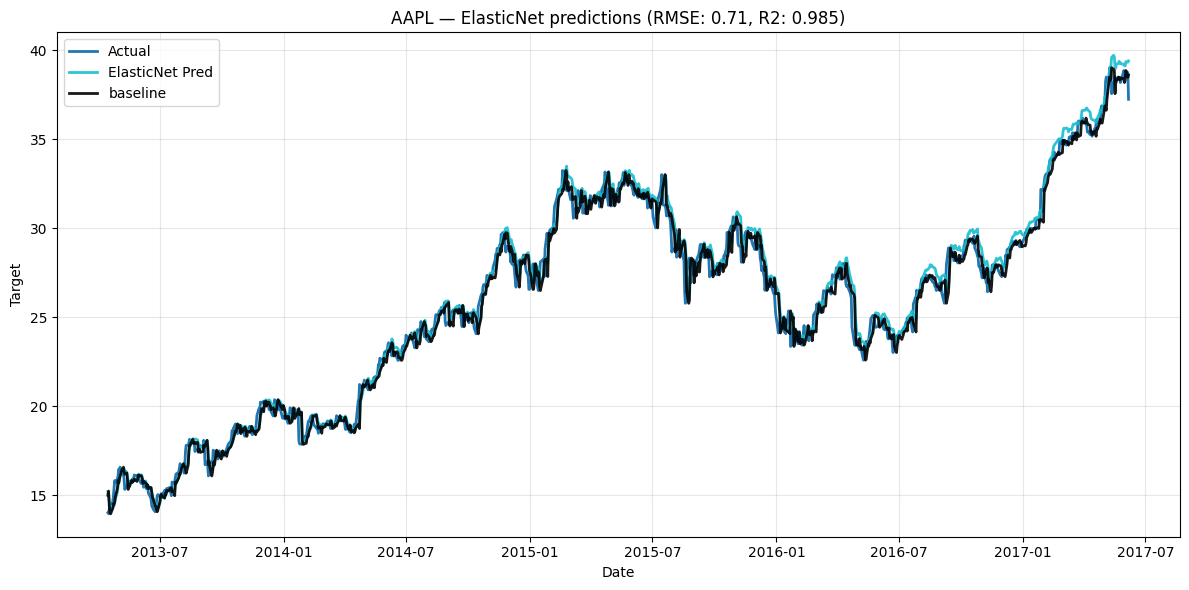

Stock: AAPL
Best params: {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.5}
RMSE: 2.6876 | MAE: 1.7244 | R2: 0.9938 | base R2: 0.9940
Top coefficients:
High          1.134973
Low           1.094703
Open          1.018912
Adj Close     0.989128
Close_lag1    0.903152
SMA           0.847813
Boll_Down     0.844785
Boll_Up       0.838037
Close_lag3    0.733795
Close_lag7    0.727034


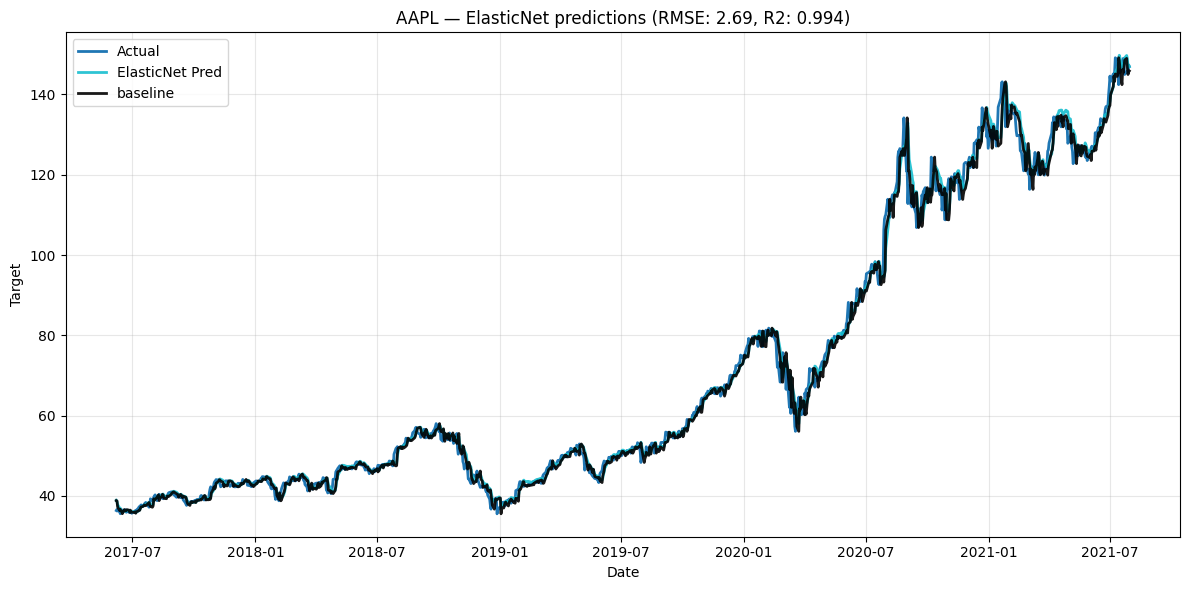

Stock: AAPL
Best params: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.9}
RMSE: 6.1982 | MAE: 4.5465 | R2: 0.9625 | base R2: 0.9672
Top coefficients:
Adj Close     3.100676
Low           3.002300
High          2.756310
Open          2.573477
Close_lag1    2.384015
Boll_Up       2.182120
Boll_Down     2.147406
SMA           2.124159
Close_lag3    1.930862
EMA50         1.910746


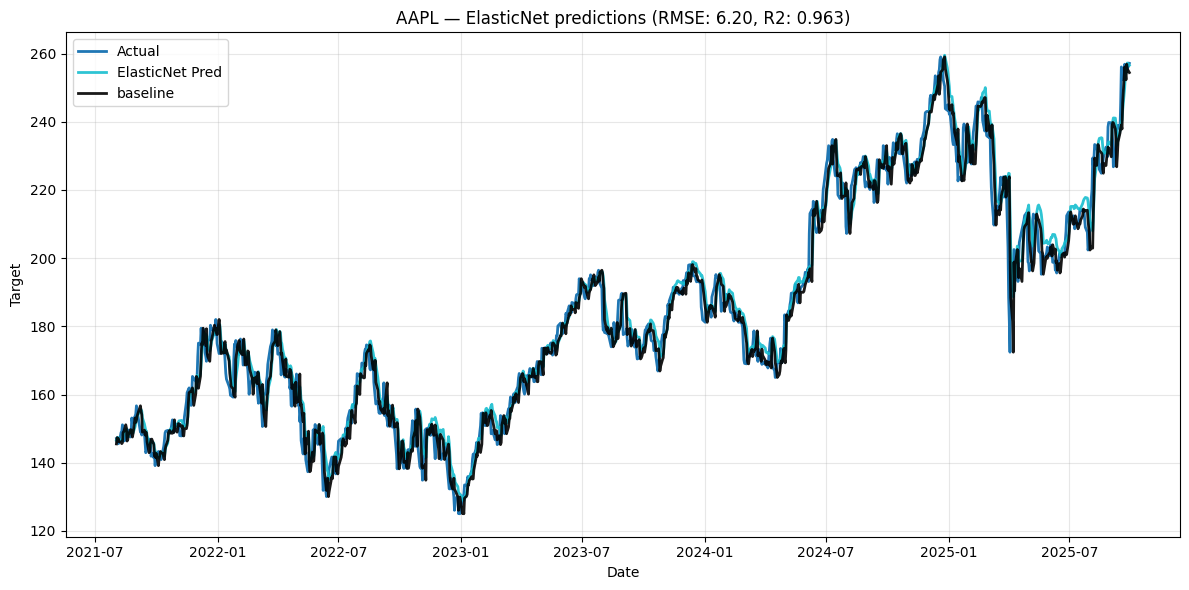

In [23]:
# Elatic-net

for data in data_set:
    pipe = make_pipeline(StandardScaler(), ElasticNet(random_state=42, max_iter=20000))

    param_grid = {
        'elasticnet__alpha': [0.01, 0.1, 0.5, 1.0],
        'elasticnet__l1_ratio': [0.1, 0.5, 0.9]
    }
    gs = GridSearchCV(pipe, param_grid, scoring='neg_mean_squared_error', cv=3, n_jobs=-1, verbose=0)
    gs.fit(data["X_train"], data["Y_train"])

    best = gs.best_estimator_
    y_pred = best.predict(data["X_test"])

    mse = mean_squared_error(data["Y_test"], y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(data["Y_test"], y_pred)
    r2 = r2_score(data["Y_test"], y_pred)
    base = r2_score(data["Y_test"], data["Reality"])

    print(f"Stock: {stock}")
    print(f"Best params: {gs.best_params_}")
    print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f} | base R2: {base:.4f}")

    # display top coefficients
    try:
        enet = best.named_steps['elasticnet']
        coefs = pd.Series(enet.coef_, index=data["X_train"].columns)
        print("Top coefficients:")
        print(coefs.abs().sort_values(ascending=False).head(10).to_string())
    except Exception:
        pass

    # plot actual vs predicted
    plt.figure(figsize=(12,6))
    plt.plot(data["Y_test"].index, data["Y_test"], label='Actual', color='#1f77b4', linewidth=2)
    plt.plot(data["Y_test"].index, y_pred, label='ElasticNet Pred', color='#17becf', linewidth=2, alpha=0.9)
    plt.plot(data["Y_test"].index, data["Reality"], label='baseline', color='#000000', linewidth=2, alpha=0.9)
    plt.title(f"{stock} — ElasticNet predictions (RMSE: {rmse:.2f}, R2: {r2:.3f})")
    plt.xlabel("Date")
    plt.ylabel("Target")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
